# I. Project Team Members

| Prepared by | Email | Prepared for |
| :-: | :-: | :-: |
| **Hardefa Rogonondo** | hardefarogonondo@gmail.com | **Car Detection and Retrieval Engine** |

# II. Notebook Target Definition

This notebook covers the training and evaluation of the object detection model for the Car Detection and Retrieval Engine project. Building on the dataset prepared in the previous notebook, we develop an object detection model from scratch using the Single Shot Multibox Detector (SSD) architecture. The process includes preprocessing the dataset and its labels, training the model, evaluating its performance, and showcasing a demo of the model using sample materials to visualize its detection capabilities.

# III. Notebook Setup

## III.A. Import Libraries

In [1]:
# !pip install roboflow
# !pip install torchmetrics

In [2]:
# from google.colab import drive
from IPython.display import clear_output, display, Image
from PIL import Image as PILImage
# from roboflow import Roboflow
from torch.utils.data import DataLoader, Dataset
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.ops import batched_nms
from torchvision import transforms, models
from tqdm import tqdm
import cv2
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os
import pandas as pd
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import xml.etree.ElementTree as ET

## III.B. Import Dataset

In [3]:
# drive.mount('/content/drive')
# dataset_path = '/content/drive/MyDrive/dataset/object_detection.zip'
# if not os.path.isdir('/content/train'):
#     print("Extracting dataset...")
#     !unzip -q '{dataset_path}' -d '/content/'
#     print(f"'{dataset_path}' extracted to '/content/' folder!")
# else:
#     print("Dataset already extracted.")

In [4]:
# train_img_path = '/content/object_detection/train/images'
# train_label_path = '/content/object_detection/train/labels'
# valid_img_path = '/content/object_detection/valid/images'
# valid_label_path = '/content/object_detection/valid/labels'
# test_img_path = '/content/object_detection/test/images'
# test_label_path = '/content/object_detection/test/labels'
# log_file_path = '/content/drive/MyDrive/dataset/ssd300_training_log.csv'
# best_model_path = '/content/drive/MyDrive/dataset/best_ssd_model.pth'

train_img_path = '../../data/object_detection/train/images'
train_label_path = '../../data/object_detection/train/labels'
valid_img_path = '../../data/object_detection/valid/images'
valid_label_path = '../../data/object_detection/valid/labels'
test_img_path = '../../data/object_detection/test/images'
test_label_path = '../../data/object_detection/test/labels'
log_file_path = '../../models/logs/ssd300_training_log.csv'
best_model_path = '../../models/best_ssd_model.pth'

## III.C. GPU Availability Checking

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_properties = torch.cuda.get_device_properties(i)
        print(f"\n--- GPU {i} Details ---")
        print(f"  Name: {gpu_name}")
        print(f"  Compute Capability: {gpu_properties.major}.{gpu_properties.minor}")
        print(f"  Total Memory: {gpu_properties.total_memory / (1024**3):.2f} GB")
        print(f"  Multiprocessor Count: {gpu_properties.multi_processor_count}")
else:
    print("CUDA is not available. Running on CPU.")

Using device: cuda
Number of GPUs available: 1

--- GPU 0 Details ---
  Name: NVIDIA GeForce GTX 1660 SUPER
  Compute Capability: 7.5
  Total Memory: 6.00 GB
  Multiprocessor Count: 22


# IV. Models Training and Evaluation

## IV.A. Training Configuration

In [6]:
img_size = 300 # Input image size for SSD300
num_classes = 7 # Number of classes + 1 for the background (6 vehicle classes + 1 background)
batch_size = 16
learning_rate = 1e-4
num_epochs = 25

In [7]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class VehicleDataset(Dataset):
    def __init__(self, img_path, label_path, transform=None):
        self.img_path = img_path
        self.label_path = label_path
        self.transform = transform
        self.imgs = [files for files in os.listdir(img_path) if files.endswith((".jpg", ".jpeg", ".png"))]
        self.class_map = {
            "background": 0,
            "bus": 1,
            "car": 2,
            "microbus": 3,
            "motorbike": 4,
            "pickup-van": 5,
            "truck": 6
        }
        self.id_to_class = {v: k for k, v in self.class_map.items()}

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_file_path = os.path.join(self.img_path, img_name)
        image = PILImage.open(img_file_path).convert('RGB')
        original_width, original_height = image.size
        label_name = os.path.splitext(img_name)[0] + ".xml"
        label_file_path = os.path.join(self.label_path, label_name)
        boxes = []
        labels = []
        if os.path.exists(label_file_path):
            tree = ET.parse(label_file_path)
            root = tree.getroot()
            for obj in root.findall("object"):
                label_name = obj.find("name").text
                if label_name in self.class_map:
                    labels.append(self.class_map[label_name])
                    bbox = obj.find("bndbox")
                    xmin = float(bbox.find("xmin").text)
                    ymin = float(bbox.find("ymin").text)
                    xmax = float(bbox.find("xmax").text)
                    ymax = float(bbox.find("ymax").text)
                    xmin_scaled = (xmin / original_width) * img_size
                    ymin_scaled = (ymin / original_height) * img_size
                    xmax_scaled = (xmax / original_width) * img_size
                    ymax_scaled = (ymax / original_height) * img_size
                    boxes.append([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled])
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        if self.transform:
            image = self.transform(image)
        if boxes.shape[0] == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels}
        return image, target

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, 0)
    return images, targets

In [8]:
train_dataset = VehicleDataset(train_img_path, train_label_path, transform=transform)
valid_dataset = VehicleDataset(valid_img_path, valid_label_path, transform=transform)
test_dataset = VehicleDataset(test_img_path, test_label_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Training dataset has {len(train_dataset)} samples.")
print(f"Validation dataset has {len(valid_dataset)} samples.")
print(f"Test dataset has {len(test_dataset)} samples.")

Training dataset has 7368 samples.
Validation dataset has 922 samples.
Test dataset has 921 samples.


## IV.B. Model Definition (SSD300)

In [9]:
class SSD300(nn.Module):
    def __init__(self, num_classes):
        super(SSD300, self).__init__()
        self.num_classes = num_classes
        vgg_features = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
        vgg_features[16] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True)
        vgg_features[23] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True)
        self.vgg_part1 = nn.ModuleList(vgg_features[:23])
        self.vgg_part2 = nn.ModuleList(vgg_features[23:30])
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
        self.aux_convs = nn.ModuleList([
            nn.Sequential( # conv8
                nn.Conv2d(1024, 256, kernel_size=1, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential( # conv9
                nn.Conv2d(512, 128, kernel_size=1, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential( # conv10
                nn.Conv2d(256, 128, kernel_size=1, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3, padding=0),
                nn.ReLU(inplace=True)
            ),
            nn.Sequential( # conv11
                nn.Conv2d(256, 128, kernel_size=1, padding=0),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, kernel_size=3, padding=0),
                nn.ReLU(inplace=True)
            )
        ])
        self.boxes_per_loc = [4, 6, 6, 6, 4, 4]
        self.loc_convs = nn.ModuleList()
        self.cls_convs = nn.ModuleList()
        in_channels = [512, 1024, 512, 256, 256, 256]
        for i in range(len(in_channels)):
            self.loc_convs.append(nn.Conv2d(in_channels[i], self.boxes_per_loc[i] * 4, kernel_size=3, padding=1))
            self.cls_convs.append(nn.Conv2d(in_channels[i], self.boxes_per_loc[i] * num_classes, kernel_size=3, padding=1))
        self.init_weights()

    def init_weights(self):
        layers_to_init = [self.conv6, self.conv7, self.aux_convs, self.loc_convs, self.cls_convs]
        for layer_group in layers_to_init:
            for m in layer_group.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)

    def forward(self, x):
        features = []
        for layer in self.vgg_part1:
            x = layer(x)
        features.append(x)
        for layer in self.vgg_part2:
            x = layer(x)
        x = self.pool5(x)
        x = F.relu(self.conv6(x), inplace=True)
        x = F.relu(self.conv7(x), inplace=True)
        features.append(x)
        for conv_block in self.aux_convs:
            x = conv_block(x)
            features.append(x)
        locs, confs = [], []
        for i, feature in enumerate(features):
            loc = self.loc_convs[i](feature).permute(0, 2, 3, 1).contiguous()
            locs.append(loc.view(loc.size(0), -1))
            conf = self.cls_convs[i](feature).permute(0, 2, 3, 1).contiguous()
            confs.append(conf.view(conf.size(0), -1))
        locs = torch.cat(locs, 1).view(locs[0].size(0), -1, 4)
        confs = torch.cat(confs, 1).view(confs[0].size(0), -1, self.num_classes)
        return locs, confs

## IV.C. Utility Functions Definition

In [10]:
def show_image_with_boxes(image_tensor, target, id_to_class_map):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_tensor_inv = inv_normalize(image_tensor)
    img = transforms.ToPILImage()(img_tensor_inv)
    width, height = img.size
    dpi = plt.rcParams['figure.dpi']
    figsize = width / float(dpi), height / float(dpi)
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.axis('off')
    ax.imshow(img)
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    for i, box in enumerate(target["boxes"]):
        xmin, ymin, xmax, ymax = box
        label_id = target["labels"][i].item()
        class_name = id_to_class_map.get(label_id, "Unknown")
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin - 10, class_name, color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))
    plt.show()

def generate_default_boxes():
    fmap_dims = {"conv4_3": 38, "conv7": 19, "conv8_2": 10, "conv9_2": 5, "conv10_2": 3, "conv11_2": 1}
    obj_scales = {"conv4_3": 0.1, "conv7": 0.2, "conv8_2": 0.375, "conv9_2": 0.55, "conv10_2": 0.725, "conv11_2": 0.9}
    aspect_ratios = {
        "conv4_3": [1., 2., 0.5],
        "conv7": [1., 2., 3., 0.5, 0.333],
        "conv8_2": [1., 2., 3., 0.5, 0.333],
        "conv9_2": [1., 2., 3., 0.5, 0.333],
        "conv10_2": [1., 2., 0.5],
        "conv11_2": [1., 2., 0.5]
    }
    default_boxes = []
    fmaps = list(fmap_dims.keys())
    for k, fmap in enumerate(fmaps):
        for i in range(fmap_dims[fmap]):
            for j in range(fmap_dims[fmap]):
                cx = (j + 0.5) / fmap_dims[fmap]
                cy = (i + 0.5) / fmap_dims[fmap]
                for ratio in aspect_ratios[fmap]:
                    default_boxes.append([cx, cy, obj_scales[fmap] * math.sqrt(ratio), obj_scales[fmap] / math.sqrt(ratio)])
                    if ratio == 1.:
                        try:
                            additional_scale = math.sqrt(obj_scales[fmap] * obj_scales[fmaps[k+1]])
                        except IndexError:
                            additional_scale = 1.
                        default_boxes.append([cx, cy, additional_scale, additional_scale])
    default_boxes = torch.tensor(default_boxes, dtype=torch.float32)
    default_boxes.clamp_(0, 1)
    return default_boxes

def iou(box1, box2):
    N = box1.size(0)
    M = box2.size(0)
    lt = torch.max(box1[:, :2].unsqueeze(1).expand(N, M, 2), box2[:, :2].unsqueeze(0).expand(N, M, 2))
    rb = torch.min(box1[:, 2:].unsqueeze(1).expand(N, M, 2), box2[:, 2:].unsqueeze(0).expand(N, M, 2))
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    area1 = area1.unsqueeze(1).expand_as(inter)
    area2 = area2.unsqueeze(0).expand_as(inter)
    union = area1 + area2 - inter
    return inter / union

def match_boxes(gt_boxes, gt_labels, default_boxes, threshold=0.5):
    if gt_boxes.size(0) == 0:
        return torch.zeros(default_boxes.size(0), 4, dtype=torch.float32, device=device), \
               torch.zeros(default_boxes.size(0), dtype=torch.long, device=device)

    d_boxes_corners = torch.cat([default_boxes[:, :2] - default_boxes[:, 2:] / 2,
                                 default_boxes[:, :2] + default_boxes[:, 2:] / 2], 1)
    gt_boxes_w = (gt_boxes[:, 2] - gt_boxes[:, 0]) / img_size
    gt_boxes_h = (gt_boxes[:, 3] - gt_boxes[:, 1]) / img_size
    gt_boxes_cx = (gt_boxes[:, 0] + gt_boxes[:, 2]) / (2 * img_size)
    gt_boxes_cy = (gt_boxes[:, 1] + gt_boxes[:, 3]) / (2 * img_size)
    gt_boxes_scaled = torch.stack([gt_boxes_cx, gt_boxes_cy, gt_boxes_w, gt_boxes_h], dim=1)
    gt_boxes_corners = torch.cat([gt_boxes_scaled[:, :2] - gt_boxes_scaled[:, 2:] / 2,
                                  gt_boxes_scaled[:, :2] + gt_boxes_scaled[:, 2:] / 2], 1)
    overlaps = iou(gt_boxes_corners, d_boxes_corners)
    best_db_for_gt_overlap, best_db_for_gt_idx = overlaps.max(dim=1)
    best_gt_for_db_overlap, best_gt_for_db_idx = overlaps.max(dim=0)
    for i in range(gt_boxes.size(0)):
        db_idx = best_db_for_gt_idx[i]
        best_gt_for_db_idx[db_idx] = i
    matches = best_gt_for_db_overlap > threshold
    matched_gt_indices = best_gt_for_db_idx[matches]
    matched_gt_box_for_db = torch.zeros(default_boxes.size(0), 4, dtype=torch.float32, device=device)
    matched_gt_label_for_db = torch.zeros(default_boxes.size(0), dtype=torch.long, device=device)
    matched_gt_box_for_db[matches] = gt_boxes_scaled[matched_gt_indices]
    matched_gt_label_for_db[matches] = gt_labels[matched_gt_indices]
    return matched_gt_box_for_db, matched_gt_label_for_db

## IV.D. Loss and Training Functions Definition

In [11]:
class MultiBoxLoss(nn.Module):
    def __init__(self, default_boxes, neg_pos_ratio=3, alpha=1.0):
        super(MultiBoxLoss, self).__init__()
        self.default_boxes = default_boxes
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha
        self.sl1_loss = nn.SmoothL1Loss(reduction='sum')
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predicted_locs, predicted_scores, gt_boxes, gt_labels):
        num_batches = predicted_locs.size(0)
        num_default_boxes = self.default_boxes.size(0)
        true_locs = []
        true_classes = []
        for i in range(num_batches):
            matched_boxes, matched_labels = match_boxes(gt_boxes[i], gt_labels[i], self.default_boxes)
            true_locs.append(matched_boxes)
            true_classes.append(matched_labels)
        true_locs = torch.stack(true_locs)
        true_classes = torch.stack(true_classes)
        positive_mask = true_classes > 0
        num_positives = positive_mask.sum(dim=1).sum()
        loc_loss = self.sl1_loss(predicted_locs[positive_mask], true_locs[positive_mask])
        conf_loss_all = self.ce_loss(predicted_scores.view(-1, num_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(num_batches, num_default_boxes)
        conf_loss_pos = conf_loss_all[positive_mask].sum()
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_mask] = 0.
        num_positives_per_image = positive_mask.sum(dim=1)
        num_neg_per_image = num_positives_per_image * self.neg_pos_ratio
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)
        hardness_ranks = torch.arange(num_default_boxes, device=device).unsqueeze(0).expand_as(conf_loss_neg)
        hard_neg_mask = hardness_ranks < num_neg_per_image.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[hard_neg_mask].sum()
        conf_loss = conf_loss_pos + conf_loss_hard_neg
        if num_positives > 0:
            total_loss = (conf_loss_pos + conf_loss_hard_neg + self.alpha * loc_loss) / num_positives
        else:
            total_loss = (conf_loss_pos + conf_loss_hard_neg + self.alpha * loc_loss)
        return total_loss

In [12]:
def post_process_predictions(predicted_locs, predicted_scores, default_boxes, num_classes, conf_thresh=0.05, nms_thresh=0.45):
    batch_size = predicted_locs.size(0)
    predicted_scores = F.softmax(predicted_scores, dim=2)
    db_cx, db_cy, db_w, db_h = default_boxes[:, 0], default_boxes[:, 1], default_boxes[:, 2], default_boxes[:, 3]
    pred_cx = db_cx + predicted_locs[:, :, 0] * 0.1 * db_w
    pred_cy = db_cy + predicted_locs[:, :, 1] * 0.1 * db_h
    pred_w = db_w * torch.exp(predicted_locs[:, :, 2] * 0.2)
    pred_h = db_h * torch.exp(predicted_locs[:, :, 3] * 0.2)
    pred_boxes_xmin = (pred_cx - pred_w / 2) * img_size
    pred_boxes_ymin = (pred_cy - pred_h / 2) * img_size
    pred_boxes_xmax = (pred_cx + pred_w / 2) * img_size
    pred_boxes_ymax = (pred_cy + pred_h / 2) * img_size
    pred_boxes = torch.stack([pred_boxes_xmin, pred_boxes_ymin, pred_boxes_xmax, pred_boxes_ymax], dim=2)
    all_batch_preds = []
    for i in range(batch_size):
        scores = predicted_scores[i][:, 1:]
        boxes = pred_boxes[i]
        conf_scores, conf_labels = torch.max(scores, dim=1)
        mask = conf_scores > conf_thresh
        if mask.sum() == 0:
            all_batch_preds.append({
                "boxes": torch.empty(0, 4, device=device),
                "scores": torch.empty(0, device=device),
                "labels": torch.empty(0, dtype=torch.int64, device=device),
            })
            continue
        final_boxes = boxes[mask]
        final_scores = conf_scores[mask]
        final_labels = conf_labels[mask] + 1 # Add 1 to correct class index (since we skipped background)
        indices_to_keep = batched_nms(final_boxes, final_scores, final_labels, nms_thresh)
        nms_boxes = final_boxes[indices_to_keep]
        nms_scores = final_scores[indices_to_keep]
        nms_labels = final_labels[indices_to_keep]
        all_batch_preds.append({
            "boxes": nms_boxes,
            "scores": nms_scores,
            "labels": nms_labels,
        })
    return all_batch_preds

def evaluate(model, data_loader, criterion, default_boxes, device):
    model.eval()
    total_loss = 0.0
    metric = MeanAveragePrecision(box_format='xyxy').to(device)
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating")
        for images, targets in progress_bar:
            images = images.to(device)
            targets_on_device = [{k: v.to(device) for k, v in t.items()} for t in targets]
            gt_boxes = [t["boxes"] for t in targets_on_device]
            gt_labels = [t["labels"] for t in targets_on_device]
            predicted_locs, predicted_scores = model(images)
            loss = criterion(predicted_locs, predicted_scores, gt_boxes, gt_labels)
            total_loss += loss.item()
            preds = post_process_predictions(predicted_locs, predicted_scores, default_boxes.to(device), num_classes)
            metric.update(preds, targets_on_device)
            progress_bar.set_postfix(loss=loss.item())
    mAP_dict = metric.compute()
    avg_loss = total_loss / len(data_loader)
    return avg_loss, mAP_dict["map"].item()

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, log_file, best_model_save_path, default_boxes):
    if not os.path.exists(log_file):
        os.makedirs(os.path.dirname(log_file), exist_ok=True)
        with open(log_file, 'w') as files:
            files.write('Epoch,Train Loss,Validation Loss,mAP,Learning Rate,Time (m)\n')
    best_valid_loss = float('inf')
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [T]")
        for images, targets in progress_bar:
            images = images.to(device)
            gt_boxes = [t["boxes"].to(device) for t in targets]
            gt_labels = [t["labels"].to(device) for t in targets]
            optimizer.zero_grad()
            predicted_locs, predicted_scores = model(images) # Forward Pass
            loss = criterion(predicted_locs, predicted_scores, gt_boxes, gt_labels) # Calculate Loss
            loss.backward() # Backpropagation
            optimizer.step() # Update Model Parameter
            train_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_valid_loss, mAP_score = evaluate(model, valid_loader, criterion, default_boxes, device)
        current_lr = optimizer.param_groups[0]["lr"]
        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        print(f'\nEpoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
        print(f'\tTrain Loss: {avg_train_loss:.4f}')
        print(f'\t Val. Loss: {avg_valid_loss:.4f}')
        print(f'\t mAP Score: {mAP_score:.4f}')
        with open(log_file, 'a') as files:
            files.write(f'{epoch+1},{avg_train_loss:.4f},{avg_valid_loss:.4f},{mAP_score:.4f},{current_lr},{epoch_mins + epoch_secs/60:.2f}\n')
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_save_path)
            print(f'\tBest model saved to {best_model_save_path} with validation loss: {best_valid_loss:.4f}\n')

## IV.E. Model Initialization

In [13]:
model = SSD300(num_classes=num_classes).to(device)
print("SSD300 model created and moved to device.")
default_boxes = generate_default_boxes().to(device)
print("Default boxes generated.")
criterion = MultiBoxLoss(default_boxes=default_boxes, neg_pos_ratio=3, alpha=1.0)
print("MultiBoxLoss function created.")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("Adam optimizer created.")

SSD300 model created and moved to device.
Default boxes generated.
MultiBoxLoss function created.
Adam optimizer created.


Displaying one sample from the training set...


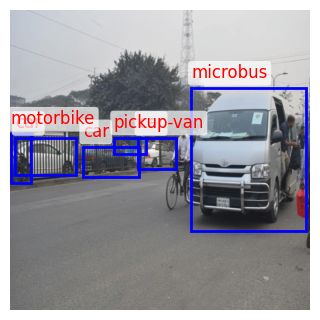

In [14]:
print("Displaying one sample from the training set...")
images, targets = next(iter(train_loader))
show_image_with_boxes(images[0], targets[0], train_dataset.id_to_class)

Displaying one sample from the validation set...


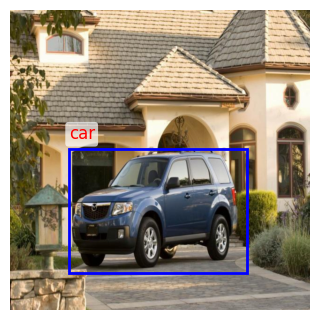

In [15]:
print("Displaying one sample from the validation set...")
images_val, targets_val = next(iter(valid_loader))
show_image_with_boxes(images_val[0], targets_val[0], valid_dataset.id_to_class)

Displaying one sample from the test set...


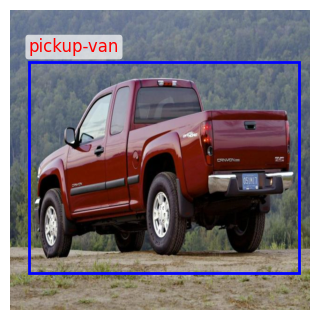

In [16]:
print("Displaying one sample from the test set...")
images_test, targets_test = next(iter(test_loader))
show_image_with_boxes(images_test[0], targets_test[0], test_dataset.id_to_class)

## IV.F. Model Training

In [17]:
print("Starting training...")
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, log_file_path, best_model_path, default_boxes)
print("Training finished.")

Starting training...


Evaluating:   0%|                                                                               | 0/58 [00:00<?, ?it/s]C:\Users\harde\anaconda3\envs\pnu\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)
Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:34<00:00,  1.69it/s, loss=3.54]



Epoch: 01 | Time: 8m 46s
	Train Loss: 3.8516
	 Val. Loss: 2.8779
	 mAP Score: 0.0516
	Best model saved to ../../models/best_ssd_model.pth with validation loss: 2.8779



Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.77]



Epoch: 02 | Time: 5m 14s
	Train Loss: 2.6469
	 Val. Loss: 2.5920
	 mAP Score: 0.0705
	Best model saved to ../../models/best_ssd_model.pth with validation loss: 2.5920



Evaluating: 100%|████████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.6]



Epoch: 03 | Time: 5m 10s
	Train Loss: 2.3112
	 Val. Loss: 2.2977
	 mAP Score: 0.1042
	Best model saved to ../../models/best_ssd_model.pth with validation loss: 2.2977



Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.04it/s, loss=2.44]



Epoch: 04 | Time: 5m 10s
	Train Loss: 2.1019
	 Val. Loss: 2.2225
	 mAP Score: 0.1068
	Best model saved to ../../models/best_ssd_model.pth with validation loss: 2.2225



Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.23]



Epoch: 05 | Time: 5m 8s
	Train Loss: 1.9438
	 Val. Loss: 2.1546
	 mAP Score: 0.1154
	Best model saved to ../../models/best_ssd_model.pth with validation loss: 2.1546



Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.34]



Epoch: 06 | Time: 5m 8s
	Train Loss: 1.7992
	 Val. Loss: 2.1299
	 mAP Score: 0.1140
	Best model saved to ../../models/best_ssd_model.pth with validation loss: 2.1299



Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.32]



Epoch: 07 | Time: 5m 9s
	Train Loss: 1.6652
	 Val. Loss: 2.1253
	 mAP Score: 0.1202
	Best model saved to ../../models/best_ssd_model.pth with validation loss: 2.1253



Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.03it/s, loss=2.03]



Epoch: 08 | Time: 5m 8s
	Train Loss: 1.5367
	 Val. Loss: 2.1578
	 mAP Score: 0.1231


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.22]



Epoch: 09 | Time: 5m 8s
	Train Loss: 1.4013
	 Val. Loss: 2.2437
	 mAP Score: 0.1195


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.16]



Epoch: 10 | Time: 5m 8s
	Train Loss: 1.2749
	 Val. Loss: 2.3249
	 mAP Score: 0.1179


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.03it/s, loss=2.41]



Epoch: 11 | Time: 5m 7s
	Train Loss: 1.1644
	 Val. Loss: 2.4258
	 mAP Score: 0.1166


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.37]



Epoch: 12 | Time: 5m 8s
	Train Loss: 1.0497
	 Val. Loss: 2.5566
	 mAP Score: 0.1149


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  2.99it/s, loss=2.54]



Epoch: 13 | Time: 5m 8s
	Train Loss: 0.9589
	 Val. Loss: 2.7000
	 mAP Score: 0.1123


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.03it/s, loss=2.83]



Epoch: 14 | Time: 5m 7s
	Train Loss: 0.8718
	 Val. Loss: 2.8419
	 mAP Score: 0.1062


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.03it/s, loss=2.92]



Epoch: 15 | Time: 5m 7s
	Train Loss: 0.8075
	 Val. Loss: 2.9789
	 mAP Score: 0.1067


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.64]



Epoch: 16 | Time: 5m 7s
	Train Loss: 0.7424
	 Val. Loss: 3.1506
	 mAP Score: 0.1089


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.03it/s, loss=2.65]



Epoch: 17 | Time: 5m 7s
	Train Loss: 0.6967
	 Val. Loss: 3.1375
	 mAP Score: 0.1098


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=3.23]



Epoch: 18 | Time: 5m 7s
	Train Loss: 0.6483
	 Val. Loss: 3.4805
	 mAP Score: 0.1051


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=2.88]



Epoch: 19 | Time: 5m 7s
	Train Loss: 0.6145
	 Val. Loss: 3.3616
	 mAP Score: 0.1044


Evaluating: 100%|████████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.01it/s, loss=3.3]



Epoch: 20 | Time: 5m 7s
	Train Loss: 0.5812
	 Val. Loss: 3.7067
	 mAP Score: 0.1075


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.02it/s, loss=3.43]



Epoch: 21 | Time: 5m 7s
	Train Loss: 0.5609
	 Val. Loss: 3.8189
	 mAP Score: 0.1074


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.03it/s, loss=3.17]



Epoch: 22 | Time: 5m 7s
	Train Loss: 0.5380
	 Val. Loss: 3.5789
	 mAP Score: 0.1035


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.03it/s, loss=3.15]



Epoch: 23 | Time: 5m 7s
	Train Loss: 0.5167
	 Val. Loss: 3.9552
	 mAP Score: 0.1030


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.01it/s, loss=3.28]



Epoch: 24 | Time: 5m 7s
	Train Loss: 0.4984
	 Val. Loss: 3.7444
	 mAP Score: 0.1030


Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  3.00it/s, loss=3.89]



Epoch: 25 | Time: 5m 7s
	Train Loss: 0.4869
	 Val. Loss: 3.8407
	 mAP Score: 0.0999
Training finished.


## IV.G. Model Testing

In [18]:
print("Starting Evaluation on Test Set...")
best_model = SSD300(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from: {best_model_path}")

Starting Evaluation on Test Set...
Loaded best model from: ../../models/best_ssd_model.pth


In [19]:
test_loss, test_mAP = evaluate(best_model, test_loader, criterion, default_boxes, device)

print("Model Performance")
print(f"Unbiased Loss on the Test Set: {test_loss:.4f}")
print(f"mAP Score on the Test Set: {test_mAP:.4f}")

Evaluating: 100%|███████████████████████████████████████████████████████████| 58/58 [00:19<00:00,  2.96it/s, loss=2.72]


Model Performance
Unbiased Loss on the Test Set: 2.1216
mAP Score on the Test Set: 0.1172


## IV.H. Model Performance Review

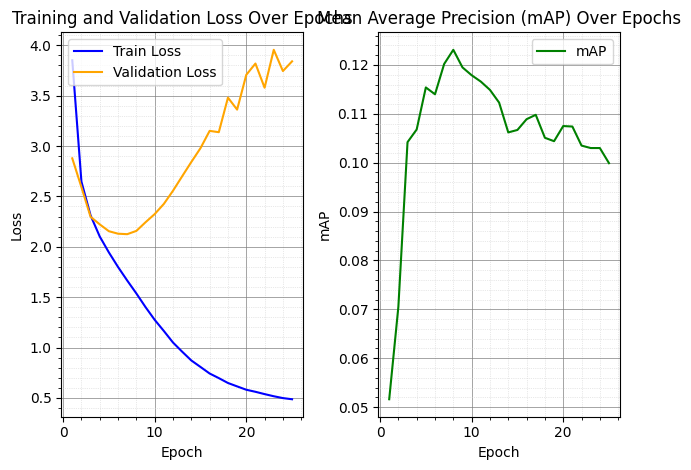

In [20]:
try:
    log_df = pd.read_csv(log_file_path)
    has_map = "mAP" in log_df.columns
    num_cols = 2 if has_map else 1
    fig, axes = plt.subplots(nrows=1, ncols=num_cols, squeeze=False)
    ax1 = axes[0, 0]
    ax1.plot(log_df["Epoch"], log_df["Train Loss"], label="Train Loss", color='blue')
    if "Validation Loss" in log_df.columns:
        ax1.plot(log_df["Epoch"], log_df["Validation Loss"], label="Validation Loss", color='orange')
    ax1.set_title("Training and Validation Loss Over Epochs")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
    ax1.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
    ax1.minorticks_on()
    if has_map:
        ax2 = axes[0, 1]
        ax2.plot(log_df["Epoch"], log_df["mAP"], label="mAP", color='green')
        ax2.set_title("Mean Average Precision (mAP) Over Epochs")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("mAP")
        ax2.legend()
        ax2.grid(True, which='major', linestyle='-', linewidth='0.5', color='gray')
        ax2.grid(True, which='minor', linestyle=':', linewidth='0.5', color='lightgray')
        ax2.minorticks_on()
    plt.tight_layout()
    plt.show()
except FileNotFoundError:
    print(f"Log file not found at: {log_file_path}")
except Exception as error:
    print(f"An error occurred while plotting the training log: {error}")

## IV.I. Model Demo

In [21]:
inference_model = SSD300(num_classes=num_classes).to(device)

try:
    inference_model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"Successfully loaded best model weights from: {best_model_path}")
except FileNotFoundError:
    print(f"ERROR: Model weights file not found at '{best_model_path}'.")
    print("Please verify the 'best_model_path' variable is correct and that the training process saved the file.")
except Exception as error:
    print(f"An error occurred while loading the model: {error}")

inference_model.eval()
print("Model is now in evaluation mode.")

id_to_class = {
    0: "background", 1: "bus", 2: "car", 3: "microbus",
    4: "motorbike", 5: "pickup-van", 6: "truck"
}

class_colors = {
    "bus": (255, 0, 0), # Blue
    "car": (0, 255, 0), # Green
    "microbus": (0, 0, 255), # Red
    "motorbike": (255, 255, 0), # Cyan
    "pickup-van": (255, 0, 255), # Magenta
    "truck": (0, 255, 255) # Yellow
}

def process_frame_with_model(frame, model, default_boxes):
    h, w, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_img = PILImage.fromarray(rgb_frame)
    image_tensor = transform(pil_img)
    input_tensor = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        predicted_locs, predicted_scores = model(input_tensor)
    preds = post_process_predictions(
        predicted_locs, predicted_scores, default_boxes,
        num_classes, conf_thresh=0.5, nms_thresh=0.45
    )
    detections = preds[0]
    if detections["boxes"].size(0) > 0:
        boxes = detections["boxes"].cpu().numpy()
        labels = detections["labels"].cpu().numpy()
        scores = detections["scores"].cpu().numpy()
        for i in range(len(boxes)):
            box = boxes[i]
            xmin, ymin, xmax, ymax = [int(c * s / img_size) for c, s in zip(box, [w, h, w, h])]
            class_name = id_to_class.get(labels[i], "Unknown")
            color = class_colors.get(class_name, (128, 128, 128))
            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
            label_text = f"{class_name}: {scores[i]:.2f}"
            (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            cv2.rectangle(frame, (xmin, ymin - 20), (xmin + tw, ymin), color, -1)
            cv2.putText(frame, label_text, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    return frame

Successfully loaded best model weights from: ../../models/best_ssd_model.pth
Model is now in evaluation mode.


In [22]:
try:
    video_path = '../../references/traffic_test.mp4'
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
    else:
        print("Successfully opened video. Starting playback with model detections...")
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                print("End of video.")
                break
            processed_frame = process_frame_with_model(frame, inference_model, default_boxes)
            _, buffer = cv2.imencode(".jpg", processed_frame)
            display(Image(data=buffer.tobytes()))
            clear_output(wait=True)
finally:
    if 'cap' in locals() and cap.isOpened():
        cap.release()
        print("Video capture released.")

End of video.
Video capture released.
